In [ ]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
import datetime
import time

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
init_notebook_mode(connected=True)

import shapefile
from shapely.geometry import Polygon

In [1]:
from descartes.patch import PolygonPatch

import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import progressbar

import seaborn as sns

predtict graph theory to max profit
  by predit
  
  
  

In [ ]:
######## Parameters #########

time_zone_interval = 60*8

######## Parameters #########



######## Function Start ########
def time_rounding(x, base=5):
    return int(base * round(float(x)/base))


def dropoff_prob_matrix(arr):
    '''compute the prbability of dropoff
    given the picuk zones
    return a matrix with row:pickup
    col: probility of dropoff'''
    total_pickups = arr.sum(axis=1)
    dim = arr.shape
    result_arr = np.zeros(dim)
    for i in range(dim[0]):
        for j in range(dim[1]):
            if total_pickups[i] == 0:
                continue
            elif arr[i,j] == 0:
                continue
            else:
                result_arr[i,j] = arr[i,j]/total_pickups[i]
    return result_arr



def add_trip_arc(start_nodes,G_round, cap, color='g'):
    '''Fro adding arc recursively'''
    
    next_iter_nodes = list() # store node for the next iteration as start nodes
    for node in start_nodes:
        
        start_zone = node[0]
        start_time = node[1]
        dropoff_zone = top_dropoff_zone_t1.loc[start_zone][0]
        try:
            distance_time = matrix_rounded_zone_distance.loc[start_zone,dropoff_zone]
        except:
            continue
        if start_time+distance_time > cap:
            continue
        G_round.add_edge((start_zone,start_time),
                         (dropoff_zone,start_time+distance_time),color=color,weight=0)
        
        next_iter_nodes.append((dropoff_zone,row_time+distance_time)) 
    return next_iter_nodes

In [339]:
def add_waste_arc(start_nodes,G_round, cap,color='yellow'):
    '''Fro adding arc recursively'''
    Next_iter_nodes = list() # store node for the next iteration as start nodes
    for node in start_nodes:
        
        start_zone = node[0]
        start_time = node[1]
        move_to_zone = top_dropoff_zone_t1.loc[start_zone][0]
        try:
            distance_time = time_rounding(trip_wait_time_table.loc[move_to_zone][0])
        except:
            continue
        if start_time+distance_time > cap:
            continue
        G_round.add_edge((start_zone,start_time),
                         (move_to_zone,start_time+distance_time),color=color,weight=distance_time)
        
        next_iter_nodes.append((dropoff_zone,row_time+distance_time)) 
    return next_iter_nodes


def Greedy_Algorithm(start_zone):
    '''Greedy algorithm search the at each states
    the minimized moving & wait time zone.
    return a path, total_trip_time & total_waste'''
    
      
    ## loading data
    matrix_PU_time= pd.read_csv('./Matrix/matrix_PU_time.csv',index_col=0)
    matrix_PU_time.columns =matrix_PU_time.columns.astype(float)

    matrix_PU_time.fillna(value=8*60, inplace=True)
    matrix_PU_wait_time = matrix_PU_time.set_index(matrix_PU_time.index.astype(int)).sort_index()
    
    matrix_zone_distance = pd.read_csv('./Matrix/full_zone_distance_matrix.csv',index_col=0)
    matrix_zone_distance.columns =matrix_zone_distance.columns.astype(int)
    matrix_zone_distance.index = matrix_zone_distance.index + 1
    temp_index = matrix_zone_distance.index
    matrix_zone_distance = matrix_zone_distance.T
    matrix_zone_distance.index = temp_index
    ind_dis = set(matrix_zone_distance.iloc[146].index)
    ind_wait_time = set(matrix_PU_wait_time[0].index)
    redundant_zones = list(ind_dis.difference(ind_wait_time))
    matrix_zone_distance = matrix_zone_distance.drop(redundant_zones, axis=1).drop(list(map(int, redundant_zones)))
    matrix_zone_distance[matrix_zone_distance.isna().any(axis=1)]
    
    matrix_prob_PU_DO_t0 = pd.read_csv('./Matrix/matrix_prob_PU_DO_t0.csv', index_col=0)
    matrix_prob_PU_DO_t0.index = matrix_prob_PU_DO_t0.index.astype(int)
    matrix_prob_PU_DO_t0.columns = matrix_prob_PU_DO_t0.columns.astype(int)
    top_dropoff_zone_t0 = pd.DataFrame(matrix_prob_PU_DO_t0.idxmax(axis=1))
    
    
    top_dropoff_zone_t1 = pd.DataFrame(matrix_prob_PU_DO_t1.idxmax(axis=1))
    
    result_path = list() # path with zone as node
    total_trip_time = 0 # total time that are making $
    total_waste_time = 0 # total time waste in move & wait
    total_time = 24*60 # time of a day
    temp_zone = start_zone # set current zone to starting zone
    
    while total_time >= 0:
        result_path.append(temp_zone)
        # compute highest pro drop off zone
        dropoff_zone = top_dropoff_zone_t1.iloc[temp_zone][0]
        result_path.append(dropoff_zone)
        
        # compute trip_time between pickup and dropoff zone
        dropoff_trip_time =  matrix_zone_distance.iloc[temp_zone,dropoff_zone]
        total_trip_time = total_trip_time + dropoff_trip_time # add trip time to total
        total_time = total_time - dropoff_trip_time # subtract the trip time from the day
        
        # compute moving_time to other zones and the wait time in other zones
        trip_wait_time_table = pd.DataFrame(np.array(matrix_zone_distance.iloc[260])
                                            + np.array(matrix_PU_wait_time[0])).sort_values(by=0)

        # looking for the min 
        local_min_cost_zone = trip_wait_time_table.idxmin()[0]
        local_min_cost_time = trip_wait_time_table.min()[0]
        
        # update current(temp) zone, total_waste time on moving and waiting, and day
        temp_zone = local_min_cost_zone
        total_waste_time = total_waste_time + local_min_cost_time
        total_time = total_time - local_min_cost_time
        
    return result_path, total_trip_time, total_waste_time




def Randomized_Greedy_Algorithm(start_zone, randomness=3):

    '''Randomized Greedy algorithm search the at each states
    the minimized moving & wait time zone. with some randomness
    return a path, total_trip_time & total_waste
    
    Args:
        start_zone(int): a int represent TLC zones as
        a starting zone of the alg
        
        randomness(float): between 0 and 1 to given some 
        randomness like entropy function, but with 1 the most
        random and 0 == Greedy Alg
        
    Retrun:
        result_list(list): path of the taxi in a day
        
        total_trip_time(float): total time that taxi is making 
            money i.e. serving customers
        
        total_waste_time(float): time moving and waiting

        '''
    
    
    ## loading data
    matrix_PU_time= pd.read_csv('./Matrix/matrix_PU_time.csv',index_col=0)
    matrix_PU_time.columns =matrix_PU_time.columns.astype(float)

    matrix_PU_time.fillna(value=8*60, inplace=True)
    matrix_PU_wait_time = matrix_PU_time.set_index(matrix_PU_time.index.astype(int)).sort_index()
    
    matrix_zone_distance = pd.read_csv('./Matrix/full_zone_distance_matrix.csv',index_col=0)
    matrix_zone_distance.columns =matrix_zone_distance.columns.astype(int)
    matrix_zone_distance.index = matrix_zone_distance.index + 1
    temp_index = matrix_zone_distance.index
    matrix_zone_distance = matrix_zone_distance.T
    matrix_zone_distance.index = temp_index
    ind_dis = set(matrix_zone_distance.iloc[146].index)
    ind_wait_time = set(matrix_PU_wait_time[0].index)
    redundant_zones = list(ind_dis.difference(ind_wait_time))
    matrix_zone_distance = matrix_zone_distance.drop(redundant_zones, axis=1).drop(list(map(int, redundant_zones)))
    matrix_zone_distance[matrix_zone_distance.isna().any(axis=1)]
    
    matrix_prob_PU_DO_t0 = pd.read_csv('./Matrix/matrix_prob_PU_DO_t0.csv', index_col=0)
    matrix_prob_PU_DO_t0.index = matrix_prob_PU_DO_t0.index.astype(int)
    matrix_prob_PU_DO_t0.columns = matrix_prob_PU_DO_t0.columns.astype(int)
    
    top_dropoff_zone_t1 = pd.DataFrame(matrix_prob_PU_DO_t1.idxmax(axis=1))
    
    
    random_number = int(-0.2/(.000000000000001-(randomness+0.000001)) +0.812)
    if random_number > 20:
        random_number = 20
    elif random_number < 1:
        random_number = 1
    result_path = list() # path with zone as node
    total_trip_time = 0 # total time that are making $
    total_waste_time = 0 # total time waste in move & wait
    total_time = 24*60 # time of a day
    temp_zone = start_zone # set current zone to starting zone
    
    while total_time >= 0:
        result_path.append(temp_zone)
        # compute highest pro drop off zone
        dropoff_zone = top_dropoff_zone_t1.iloc[temp_zone][0]
        result_path.append(dropoff_zone)
        
        # compute trip_time between pickup and dropoff zone
        dropoff_trip_time =  matrix_zone_distance.iloc[temp_zone,dropoff_zone]
        total_trip_time = total_trip_time + dropoff_trip_time # add trip time to total
        total_time = total_time - dropoff_trip_time # subtract the trip time from the day
        
        # compute moving_time to other zones and the wait time in other zones
        trip_wait_time_table = pd.DataFrame(np.array(matrix_zone_distance.iloc[260])
                                            + np.array(matrix_PU_wait_time[0])).sort_values(by=0)

        # looking for the min 
        trip_wait_time_table = trip_wait_time_table[:20].sample(random_number)
        local_min_cost_zone = trip_wait_time_table.idxmin()[0]
        local_min_cost_time = trip_wait_time_table.min()[0]
        
        # update current(temp) zone, total_waste time on moving and waiting, and day
        temp_zone = local_min_cost_zone
        total_waste_time = total_waste_time + local_min_cost_time
        total_time = total_time - local_min_cost_time
        
    return result_path, total_trip_time, total_waste_time



class Exponential:

    def __init__(self, rate):
        self.rate = rate

    def prob_less_than_or_equal(self, t):
        rate = self.rate * t
        return 1 - np.exp(-rate)

    def prob_greater_than(self, t):
        return 1 - self.prob_less_than_or_equal(t)

    def prob_between(self, t1, t2):
        p1 = self.prob_less_than_or_equal(t1)
        p2 = self.prob_less_than_or_equal(t2)

        return p2 - p1


expo = Exponential(2)
print(expo.prob_less_than_or_equal(0.25))
print(expo.prob_between(0.25, 0.5))


######## Function End ########

0.3934693402873666
0.2386512185411911


In [3]:
%%time
yellow = pd.read_csv('./Data/yellow.csv')
yellow.head()

<string>:2: DtypeWarning:

Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.



CPU times: user 20.7 s, sys: 2.36 s, total: 23.1 s
Wall time: 23.1 s


In [4]:
# create timezone with interval 15min
yellow['Time_Diff'] = pd.to_datetime(yellow['tpep_dropoff_datetime']) - pd.to_datetime(yellow['tpep_pickup_datetime'])
yellow_new = yellow.iloc[:7781158,]
yellow_new.shape
yellow_new['Time_Diff'].mean()
yellow_new['dropoff_datetime'] = yellow_new['tpep_dropoff_datetime'].str[11:13].astype(float) * 60 + yellow_new['tpep_dropoff_datetime'].str[14:16].astype(float) + yellow_new['tpep_dropoff_datetime'].str[17:19].astype(float) / 60
yellow_new['pickup_datetime'] = yellow_new['tpep_pickup_datetime'].str[11:13].astype(float) * 60 + yellow_new['tpep_pickup_datetime'].str[14:16].astype(float) + yellow_new['tpep_pickup_datetime'].str[17:19].astype(float) / 60
yellow_new['dropoff_timezone'] = (yellow_new['dropoff_datetime'] //time_zone_interval)
yellow_new['pickup_timezone'] = (yellow_new['pickup_datetime'] // time_zone_interval)

yellow_new['pickup_date'] = pd.to_datetime(yellow_new['tpep_pickup_datetime']).dt.date
yellow_new['dropoff_date'] = pd.to_datetime(yellow_new['tpep_dropoff_datetime']).dt.date
yellow_new = yellow_new[yellow_new['pickup_date']==yellow_new['dropoff_date']]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [5]:
yellow_new.shape

(7696006, 27)

In [6]:
loc_ids = list(range(266))
num_loc_ids = len(loc_ids)

time_zones = list(yellow_new['pickup_timezone'].unique())
time_zones = sorted(time_zones)
num_time_zones = len(time_zones)
print(num_loc_ids)
print(num_time_zones)

266
3


In [7]:
## create 2-d matrix to with each row as PULocationID and each col as the time_zone
matrix_PU_time = pd.DataFrame() # create empty dataframe

for time_zone in  time_zones:
    temp_df = (time_zone_interval / (yellow_new[yellow_new['pickup_timezone']==time_zone]
                                    .groupby(['PULocationID'])['DOLocationID']
                                    .agg(['count'])))
    temp_df.rename(index=str, columns={"count": time_zone},inplace=True)
    matrix_PU_time = matrix_PU_time.merge(temp_df,
                                                how='outer',
                                                left_index = True,
                                                right_index = True)
    
matrix_PU_time.shape

(262, 3)

In [10]:
matrix_PU_time.to_csv('./Matrix/matrix_PU_time.csv')

In [11]:
matrix_PU_time.fillna(value=time_zone_interval, inplace=True)
matrix_PU_wait_time = matrix_PU_time.set_index(matrix_PU_time.index.astype(int)).sort_index()

In [12]:
arr_time_PU_DO = np.zeros([num_time_zones,num_loc_ids,num_loc_ids])
print(('1d: each time_zone'
      +'\n2d: each pick up zone'
      +'\n3d: each dropoff zone'))
arr_time_PU_DO.shape

1d: each time_zone
2d: each pick up zone
3d: each dropoff zone


(3, 266, 266)

In [13]:
%%time
bar = progressbar.ProgressBar(max_value=num_time_zones-1)
for time_zone in range(num_time_zones):
    
    bar.update(time_zone)# print out the progress and running time
    
    temp_PU_DO = (yellow_new[yellow_new['pickup_timezone']==time_zone]
               .groupby(['PULocationID'])['DOLocationID']
               .value_counts()).unstack(fill_value=0)

    temp_arr = np.zeros([num_loc_ids,num_loc_ids])
    for i in range(num_loc_ids): 
        for j in range(num_loc_ids):
            try:
                temp_arr[i,j] = temp_PU_DO.loc[i,j]
            except:
                continue
    arr_time_PU_DO[time_zone] =  temp_arr

100% (2 of 2) |##########################| Elapsed Time: 0:00:06 ETA:  00:00:00

CPU times: user 7.3 s, sys: 2.69 s, total: 9.99 s
Wall time: 10.1 s


In [14]:
arr_time_PU_DO.shape

(3, 266, 266)

In [15]:
## create a probability array that given a time zone,  it have row as a pickup loc and col as prob(dropoff loc)
arr_prob_PU_DO = np.zeros(arr_time_PU_DO.shape)  # create a 3-d array of the same shape of arr_time_PU_DO
for time_zone in range(num_time_zones):
    arr_prob_PU_DO[time_zone] = dropoff_prob_matrix(arr_time_PU_DO[time_zone])

In [16]:
## loading the distance matrix(compute from the full_yellow.csv)
M = 1000000000000 # large number
zone_dis = pd.read_csv('./Matrix/zone_distance_matrix.csv', index_col=0)

In [17]:
matrix_zone_distance = pd.read_csv('./Matrix/full_zone_distance_matrix.csv',index_col=0)
matrix_zone_distance.index = matrix_zone_distance.index + 1
temp_index = matrix_zone_distance.index
matrix_zone_distance = matrix_zone_distance.T
matrix_zone_distance.index = temp_index
matrix_zone_distance
matrix_zone_distance.shape

(265, 265)

In [18]:
ind_dis = set(matrix_zone_distance.iloc[146].index)
ind_wait_time = set(matrix_PU_wait_time[0].index)
redundant_zones = list(ind_dis.difference(ind_wait_time))
redundant_zones
matrix_zone_distance = matrix_zone_distance.drop(redundant_zones, axis=1).drop(list(map(int, redundant_zones)))
matrix_zone_distance[matrix_zone_distance.isna().any(axis=1)]
matrix_zone_distance.shape

(262, 262)

In [20]:
matrix_zone_distance = pd.read_csv('./Matrix/full_zone_distance_matrix.csv',index_col=0)
matrix_zone_distance.index = matrix_zone_distance.index + 1
temp_index = matrix_zone_distance.index
matrix_zone_distance = matrix_zone_distance.T
matrix_zone_distance.index = temp_index
ind_dis = set(matrix_zone_distance.iloc[146].index)
ind_wait_time = set(matrix_PU_wait_time[0].index)
redundant_zones = list(ind_dis.difference(ind_wait_time))
matrix_zone_distance = matrix_zone_distance.drop(redundant_zones, axis=1).drop(list(map(int, redundant_zones)))
matrix_zone_distance[matrix_zone_distance.isna().any(axis=1)]
matrix_zone_distance.shape

(262, 262)

In [21]:
matrix_zone_distance
matrix_PU_wait_time
arr_prob_PU_DO.shape

(3, 266, 266)

In [30]:
matrix_prob_PU_DO_t0 = pd.DataFrame(arr_prob_PU_DO[0])
matrix_prob_PU_DO_t1 = pd.DataFrame(arr_prob_PU_DO[1])
matrix_prob_PU_DO_t2 = pd.DataFrame(arr_prob_PU_DO[2])

In [31]:
matrix_prob_PU_DO_t0.iloc[104]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
22     0.0
23     0.0
24     0.0
25     0.0
26     0.0
27     0.0
28     0.0
29     0.0
      ... 
236    0.0
237    0.0
238    0.0
239    0.0
240    0.0
241    0.0
242    0.0
243    0.0
244    0.0
245    0.0
246    0.0
247    0.0
248    0.0
249    0.0
250    0.0
251    0.0
252    0.0
253    0.0
254    0.0
255    0.0
256    0.0
257    0.0
258    0.0
259    0.0
260    0.0
261    0.0
262    0.0
263    0.0
264    0.0
265    0.0
Name: 104, Length: 266, dtype: float64

In [32]:
matrix_zone_distance.iloc[104,0]

35.38333333333335

In [33]:

pd.DataFrame(np.array(matrix_zone_distance.iloc[260]) + np.array(matrix_PU_wait_time[0])).sort_values(by=0).min()


0    1.671495
dtype: float64

In [38]:
top_dropoff_zone_t1 = pd.DataFrame(matrix_prob_PU_DO_t1.idxmax(axis=1))
top_dropoff_zone_t1.iloc[98][0]

98

In [39]:
path = Randomized_Greedy_Algorithm(66, 1)[0]

In [41]:
from Taxi import graph_path
graph_path(path)

In [46]:
matrix_zone_distance.max().max()

731.7833333333333

In [47]:
matrix_rounded_zone_distance = pd.DataFrame()
for col in matrix_zone_distance.columns:
    matrix_rounded_zone_distance[col] = (matrix_zone_distance[col]
                                             .fillna(matrix_zone_distance.max().max())
                                             .apply(time_rounding))
    
matrix_rounded_zone_distance = matrix_rounded_zone_distance.replace(0,5)

In [496]:
G_round = nx.DiGraph()
# add s and t nodes
G_round.add_node('source', pos=(matrix_rounded_zone_distance.index[130],25))
G_round.add_node('sink', pos=(matrix_rounded_zone_distance.index[130],-45*5))

## add arc from and to s and t
start_nodes = (zip(matrix_rounded_zone_distance.index,
                       (0 for i in matrix_rounded_zone_distance.index)))
#nearest to t
terminal_nodes = (zip(matrix_rounded_zone_distance.index,
                       (39*5 for i in matrix_rounded_zone_distance.index)))
#second nearest to t
terminal2_nodes = (zip(matrix_rounded_zone_distance.index,
                       (38*5 for i in matrix_rounded_zone_distance.index)))
for i in start_nodes:
    G_round.add_edge('source',i, color='b',weight=0)
        
for i in terminal_nodes:
    G_round.add_edge(i,'sink', color='b',weight=0)

for i in terminal2_nodes:
    G_round.add_edge(i,'sink', color='b',weight=0)

    
## create nodes
matrix_nodes = pd.DataFrame()
time_itr = range(0,40*5,5)
for col in matrix_rounded_zone_distance.index:
        matrix_nodes[col] = [0 for i in time_itr]
matrix_nodes.index = list(time_itr)

for col in matrix_rounded_zone_distance.index:
    for row in time_itr:
#         matrix_nodes[col].loc[row] = str(col)+','+str(row)
        G_round.add_node((col,row),pos=(col,-row))


In [497]:
top_dropoff_zone_t1 = pd.DataFrame(matrix_prob_PU_DO_t1.idxmax(axis=1))

In [498]:
trip_wait_time_table = pd.DataFrame(np.array(matrix_zone_distance.iloc[260])
                                            + np.array(matrix_PU_wait_time[0])).sort_values(by=0)

In [499]:
trip_wait_time_table.loc[20][0]

10.936764705882354

In [500]:
def add_trip_arc(start_nodes,G_round, cap, color='g'):
    '''Fro adding arc recursively'''
    
    next_iter_nodes = list() # store node for the next iteration as start nodes
    for node in start_nodes:
        
        start_zone = node[0]
        start_time = node[1]
        dropoff_zone = top_dropoff_zone_t1.loc[start_zone][0]
        try:
            distance_time = matrix_rounded_zone_distance.loc[start_zone,dropoff_zone]
        except:
            print('========',start_zone,dropoff_zone,'=========')
            continue
        if start_time+distance_time > cap:
            continue
        G_round.add_edge((start_zone,start_time),
                         (dropoff_zone,start_time+distance_time),color=color,weight=0)
        
        next_iter_nodes.append((dropoff_zone,row_time+distance_time)) 
    return next_iter_nodes

In [501]:
def add_waste_arc(start_nodes,G_round, cap,color='yellow'):
    '''Fro adding arc recursively'''
    Next_iter_nodes = list() # store node for the next iteration as start nodes
    for node in start_nodes:
        
        start_zone = node[0]
        start_time = node[1]
        move_to_zone = trip_wait_time_table.sample(3).idxmin()[0]
        try:
            distance_time = time_rounding(trip_wait_time_table.loc[move_to_zone][0])
        except:
#             distance_time = time_rounding(5*np.random.randint(5)) 
            continue
        if distance_time < 5:
            distance_time += 5
        if start_time+distance_time > cap:
            continue
        G_round.add_edge((start_zone,start_time),
                         (move_to_zone,start_time+distance_time),color=color,weight=distance_time)
        
        next_iter_nodes.append((dropoff_zone,row_time+distance_time)) 
    return next_iter_nodes

In [502]:
start_nodes = (zip(matrix_rounded_zone_distance.index,
                       (0 for i in matrix_rounded_zone_distance.index)))
cap = 40*5 - 5
even_itr_nodes =  add_trip_arc(start_nodes,G_round,cap)
for i in range(2):
  
    if i%2:
        even_itr_nodes = add_trip_arc(odd_itr_nodes,G_round,cap)
        odd_itr_nodes = None
        print(i,'---------')
    else:
        odd_itr_nodes = add_waste_arc(even_itr_nodes, G_round,cap)
        even_itr_nodes = None
        print(i)
    

======== 104 0 =========
======== 172 0 =========
======== 204 0 =========
0
1 ---------


In [517]:
for node in G_round.nodes:
    if type(node)!=str:
        G_round.nodes[node]['pos'] = (node[0],-node[1] )

In [520]:
nx.dijkstra_path(G=G_round,source='source',target='sink')

NetworkXNoPath: No path to sink.

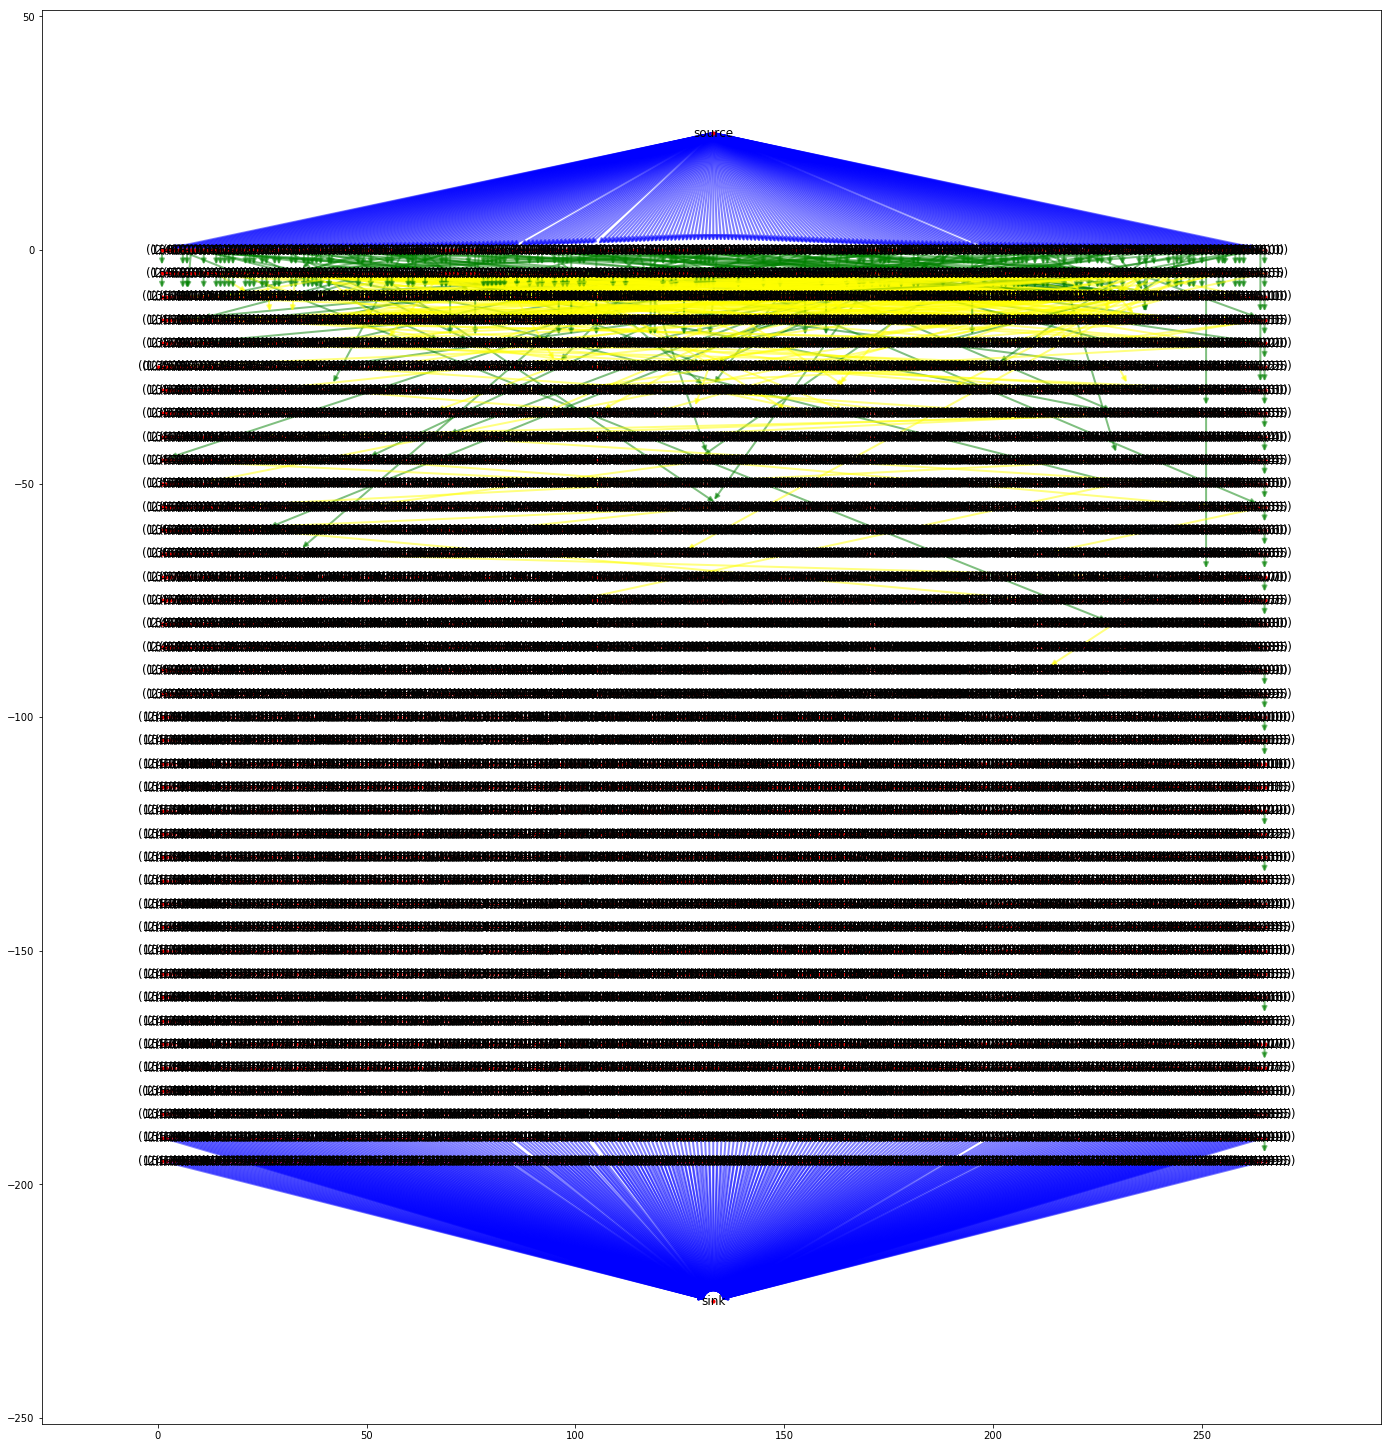

CPU times: user 49.5 s, sys: 12.4 s, total: 1min 1s
Wall time: 1min 1s


In [521]:
%%time
edge_colors = [G_round[u][v]['color'] for u,v in G_round.edges]
plt.figure(1,figsize=(24,26))

pos = nx.get_node_attributes(G_round, 'pos')
# pos = nx.spring_layout(G_round)
nx.draw_networkx_nodes(G_round,pos,node_size=10,font_size=7,width=8,alpha=1.0)
nx.draw_networkx_edges(G_round,pos,font_size=7,edgelist=G_round.edges(),
                       width=2,alpha=0.5,edge_color=edge_colors,edge_size=2)


nx.draw_networkx_labels(G_round, pos)
# nx.draw(G_round, pos, with_labels=True, node_size=0)
plt.axis('on')
plt.show()